In [1]:
import numpy as np
import matplotlib.pyplot as plt
from empiricaldist import Pmf, Cdf
from thinkstats import decorate, two_bar_plots, read_brfss
from scipy.special import comb, factorial
from scipy.stats import norm, trimboth
import pandas as pd
import nsfg
import statadict
from nsfg import read_fem_resp

In [2]:
def flip(n, p):
    choices = [1, 0]
    probs = [p, 1 - p]
    return np.random.choice(choices, n, p = probs)

In [3]:
flip(25, 0.9)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1])

In [4]:
seq = flip(1000, 0.9)
pmf = Pmf.from_seq(seq)
pmf

,probs
0,0.086
1,0.914


In [5]:
def simulate_round(n, p):
    seq = flip(n, p)
    return seq.sum()

In [6]:
n = 25
p = 0.9
result_sim = [simulate_round(n,p) for i in range(1000)]

In [7]:
np.mean(result_sim), n * p

(np.float64(22.478), 22.5)

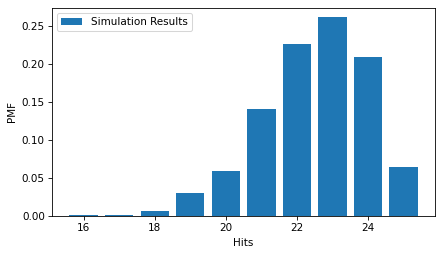

In [8]:
pmf_sim = Pmf.from_seq(result_sim, name = "Simulation Results")
pmf_sim.bar()
decorate(xlabel = "Hits", ylabel = "PMF")

In [9]:
def binomial_pmf(k, n, p):
    return comb(n,k) * (p**k) * ((1-p) ** (n-k))

In [10]:
ks = np.arange(16, n + 1)
ps = binomial_pmf(ks, n, p)
pmf_binom = Pmf(ps, ks, name = "Binomial Model")

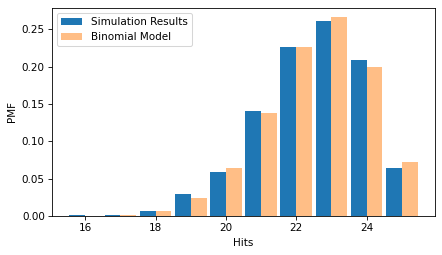

In [11]:
two_bar_plots(pmf_sim, pmf_binom)
decorate(xlabel = "Hits", ylabel = "PMF")

In [12]:
filename = "Shooting_at_the_2020_Summer_Olympics_Mens_skeet"

In [13]:
data = pd.read_html(filename)

In [14]:
df = data[6]
df.head()

,Rank,Athlete,Country,1,2,3,4,5,Total[3],Shoot-off,Notes
0,1,Éric Delaunay,France,25,25,25,24,25,124,+6,"Q, OR"
1,2,Tammaro Cassandro,Italy,24,25,25,25,25,124,+5,"Q, OR"
2,3,Eetu Kallioinen,Finland,25,25,24,25,24,123,NaN,Q
3,4,Vincent Hancock,United States,25,25,25,25,22,122,+8,Q
4,5,Abdullah Al-Rashidi,Kuwait,25,25,24,25,23,122,+7,Q


In [15]:
columns = ["1", "2", "3", "4", "5"]
results = df[columns].values.flatten()

In [16]:
total_shots = 25 * len(results)
total_hits = results.sum()
n, total_shots, total_hits

(25, 3750, np.int64(3575))

In [17]:
p = total_hits / total_shots
p

np.float64(0.9533333333333334)

In [18]:
ps = binomial_pmf(ks, n, p)
pmf_binom = Pmf(ps, ks, name = "Binomial Model")

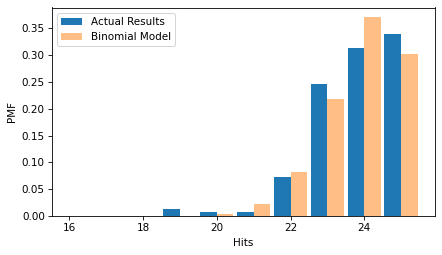

In [19]:
pmf_result = Pmf.from_seq(results, name = "Actual Results")
two_bar_plots(pmf_result, pmf_binom)
decorate(xlabel="Hits", ylabel="PMF")

In [20]:
n = 3600
m = 6
p = m / 3600
p

0.0016666666666666668

In [21]:
def simulate_goals(n,p):
    return flip(n, p).sum()

In [22]:
goals = [simulate_goals(n,p) for i in range(1001)]
np.mean(goals)

np.float64(5.968031968031968)

In [23]:
def poisson_pmf(k,lam):
    return (lam**k) * np.exp(-lam) / factorial(k)

In [24]:
lam = 6
ks = np.arange(20)
ps = poisson_pmf(ks, lam)
pmf_poisson = Pmf(ps, ks, name="Poisson model")

In [25]:
pmf_poisson.normalize()
pmf_poisson.mean()

np.float64(5.999925498375129)

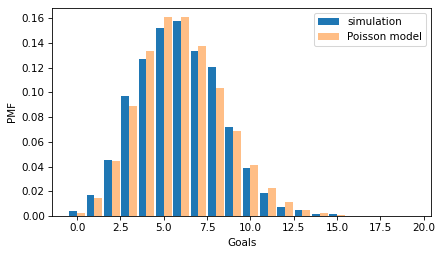

In [26]:
pmf_sim = Pmf.from_seq(goals, name="simulation")

two_bar_plots(pmf_sim, pmf_poisson)
decorate(xlabel="Goals", ylabel="PMF")

In [27]:
filename = "nhl_2023_2024.hdf"

with pd.HDFStore(filename, "r") as store:
    keys = store.keys()

len(keys), keys[0]

(1312, '/202310100PIT')

In [28]:
times = pd.read_hdf(filename, key = keys[0])
times

0     424
1    1916
2    2137
3    3005
4    3329
5    3513
dtype: int64

In [29]:
3600 - times[5]

np.int64(87)

In [30]:
goals = []

for key in keys:
    times = pd.read_hdf(filename, key=key)
    n = len(times)
    goals.append(n)

In [31]:
lam = np.mean(goals)
lam

np.float64(6.0182926829268295)

In [32]:
ps = poisson_pmf(ks, lam)
pmf_poisson = Pmf(ps, ks, name="Poisson model")

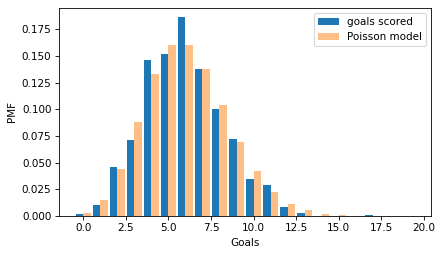

In [33]:
pmf_goals = Pmf.from_seq(goals, name="goals scored")

two_bar_plots(pmf_goals, pmf_poisson)
decorate(xlabel="Goals", ylabel="PMF")

In [34]:
n = 3600
m = 6
p = m/3600
p

0.0016666666666666668

In [35]:
def simulate_first_goal(n, p):
    return flip(n, p).argmax()

In [36]:
first_goal_times = [simulate_first_goal(n, p) for i in range(1001)]
mean = np.mean(first_goal_times)
mean

np.float64(593.8701298701299)

In [37]:
def exponential_cdf(x, len):
    return 1 - np.exp(-lam * x)

In [38]:
lam = 1/mean
lam

np.float64(0.0016838698390482854)

In [39]:
ts = np.linspace(0, 3600, 201)
ps = exponential_cdf(ts, lam)
cdf_expo = Cdf(ps, ts, name = "Exponential Model")

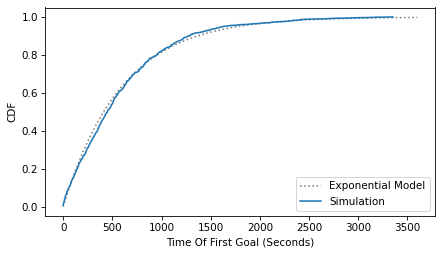

In [40]:
cdf_sim = Cdf.from_seq(first_goal_times, name = "Simulation")
cdf_expo.plot(ls = ":", color = "gray")
cdf_sim.plot()
decorate(xlabel = "Time Of First Goal (Seconds)", ylabel = "CDF")

In [41]:
firsts = []
for key in keys:
    times = pd.read_hdf(filename , key = key)
    if len(times) > 0:
        firsts.append(times[0])
    else:
        firsts.append(np.nan)

In [42]:
lam = 1 / np.nanmean(firsts)
lam

np.float64(0.0015121567467720825)

In [43]:
ps = exponential_cdf(ts, lam)
cdf_expo = Cdf(ps, ts, name = "Exponential Model")

In [44]:
cdf_firsts = Cdf.from_seq(firsts, name = "Data", dropna = False)
cdf_firsts.tail()

,probs
3286.0,0.996951
3581.0,0.997713
NaN,1.000000


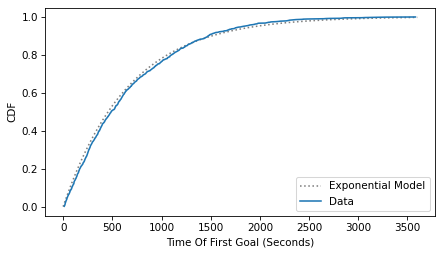

In [45]:
cdf_expo.plot(ls = ":", color = "gray")
cdf_firsts.plot()
decorate(xlabel = "Time Of First Goal (Seconds)", ylabel = "CDF")

In [46]:
def simulate_growth(n):
    choices = [1,2,3]
    gains = np.random.choice(choices,n)
    return gains.sum()

In [47]:
sim_weights = [simulate_growth(100) for i in range(1001)]
m, s = np.mean(sim_weights), np.std(sim_weights)
m, s

(np.float64(199.77022977022978), np.float64(8.257902874656832))

In [48]:
def make_normal_model(data):
    m, s = np.mean(data), np.std(data)
    low, high = m - 4 * s, m + 4 * s
    qs = np.linspace(low, high, 201)
    ps = norm.cdf(qs, m, s)
    return Cdf(ps, qs, name="normal model")

In [49]:
cdf_model = make_normal_model(sim_weights)

In [50]:
cdf_sim_weights = Cdf.from_seq(sim_weights, name="simulation")

In [51]:
def two_cdf_plots(cdf_model, cdf_data, xlabel="", **options):
    cdf_model.plot(ls=":", color="gray")
    cdf_data.plot(**options)
    decorate(xlabel=xlabel, ylabel="CDF")

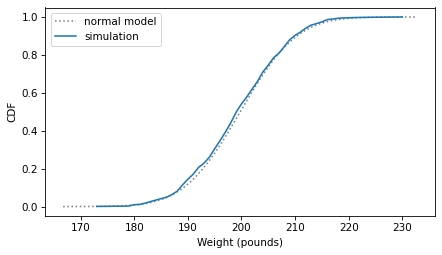

In [52]:
two_cdf_plots(cdf_model, cdf_sim_weights, xlabel="Weight (pounds)")

In [53]:
preg = nsfg.read_fem_preg()
birth_weights = preg["totalwgt_lb"].dropna()

In [54]:
m, s = np.mean(birth_weights), np.std(birth_weights)
m, s

(np.float64(7.265628457623368), np.float64(1.40821553384062))

In [55]:
trimmed = trimboth(birth_weights, 0.01)
m, s = np.mean(trimmed), np.std(trimmed)
m, s

(np.float64(7.280883100022579), np.float64(1.2430657948614345))

In [56]:
cdf_model = make_normal_model(trimmed)

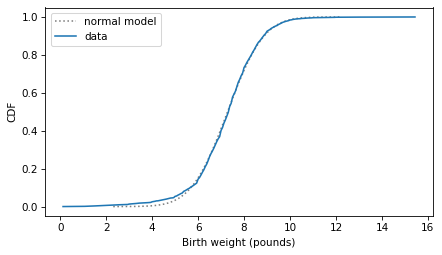

In [57]:
cdf_birth_weight = Cdf.from_seq(birth_weights, name='data')

two_cdf_plots(cdf_model, cdf_birth_weight, xlabel="Birth weight (pounds)")

In [58]:
def simulate_proportionate_growth(n):
    choices = [1.03, 1.05, 1.07]
    gains = np.random.choice(choices, n)
    return gains.prod()

In [59]:
sim_weights = [simulate_proportionate_growth(100) for i in range(1001)]
np.mean(sim_weights), np.std(sim_weights)

(np.float64(131.31578348881766), np.float64(20.124757437918863))

In [60]:
log_sim_weights = np.log10(sim_weights)
m, s = np.mean(log_sim_weights), np.std(log_sim_weights)
m, s

(np.float64(2.1133005657326396), np.float64(0.06592646970470906))

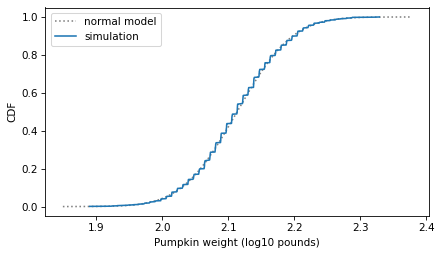

In [61]:
cdf_model = make_normal_model(log_sim_weights)
cdf_log_sim_weights = Cdf.from_seq(log_sim_weights, name="simulation")

two_cdf_plots(
    cdf_model, cdf_log_sim_weights, xlabel="Pumpkin weight (log10 pounds)"
)

In [62]:
brfss = read_brfss()

In [63]:
adult_weights = brfss["wtkg2"].dropna()
m, s = np.mean(adult_weights), np.std(adult_weights)
m, s

(np.float64(78.9924529968581), np.float64(19.546132387397257))

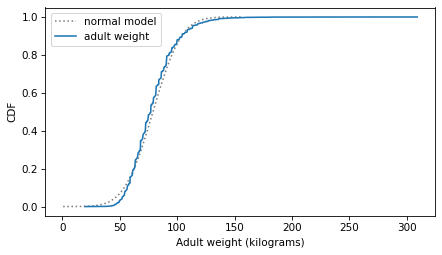

In [64]:
cdf_model = make_normal_model(adult_weights)
cdf_adult_weights = Cdf.from_seq(adult_weights, name="adult weight")

two_cdf_plots(cdf_model, cdf_adult_weights, xlabel="Adult weight (kilograms)")

In [65]:
log_adult_weights = np.log10(adult_weights)
cdf_model = make_normal_model(log_adult_weights)

cdf_log_adult_weights = Cdf.from_seq(log_adult_weights, name="log adult weight")

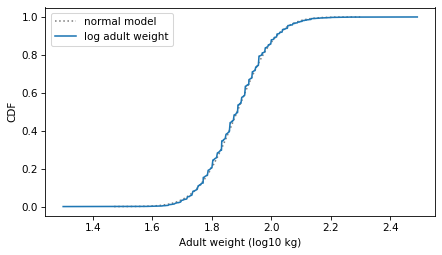

In [66]:
two_cdf_plots(cdf_model, cdf_log_adult_weights, xlabel="Adult weight (log10 kg)")

In [67]:
df = read_fem_resp()

In [68]:
older = df.query("age >= 25")
num_family = older["numfmhh"]

In [69]:
pmf = Pmf.from_seq(num_family, name = "Older Respondents")

In [70]:
lam = num_family.mean()                    
ks = np.arange(0, num_family.max()+1)

In [71]:
ps = poisson_pmf(ks, lam)
pmf_poisson = Pmf(ps, ks, name="Poisson model")

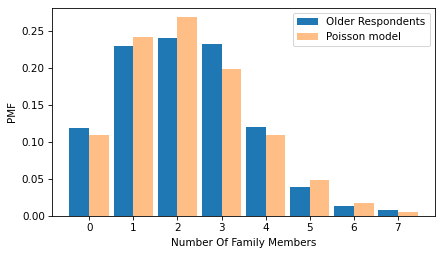

In [72]:
two_bar_plots(pmf, pmf_poisson)
decorate(xlabel="Number Of Family Members", ylabel="PMF")

In [73]:
filename = "nhl_2023_2024.hdf"

with pd.HDFStore(filename, "r") as store:
    keys = store.keys()

In [74]:
intervals = []

for key in keys:
    times = pd.read_hdf(filename, key=key)
    if len(times) > 1:
        intervals.extend(times.diff().dropna())

In [75]:
cdf = Cdf.from_seq(intervals)

In [76]:
mean = np.mean(intervals)

In [77]:
lam = 1/mean
lam

np.float64(0.002040836560191201)

In [78]:
ts = np.linspace(0, max(intervals), num=101)

In [79]:
ps = exponential_cdf(ts, lam)
cdf_expo = Cdf(ps, ts, name = "Exponential Model")

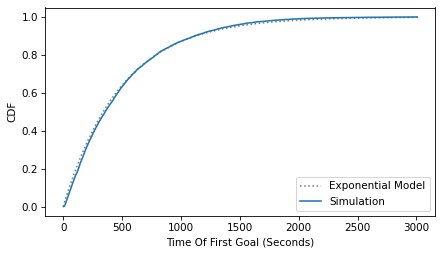

In [80]:
cdf_sim = Cdf.from_seq(intervals, name = "Simulation")
cdf_expo.plot(ls = ":", color = "gray")
cdf_sim.plot()
decorate(xlabel = "Time Of First Goal (Seconds)", ylabel = "CDF")

In [81]:
adult_heights = brfss["htm3"].dropna()
m, s = np.mean(adult_heights), np.std(adult_heights)
m, s

(np.float64(168.82518961012298), np.float64(10.35264015645592))

In [82]:
cdf_heights = Cdf.from_seq(adult_heights)

In [83]:
xs = np.linspace(min(adult_heights), max(adult_heights), 201)
ps_normal = norm.cdf(xs, loc=m, scale=s)
cdf_normal = Cdf(ps_normal, xs, name="Normal model")

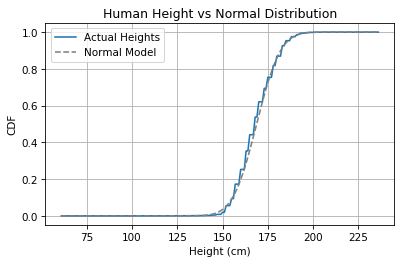

In [84]:
cdf_heights.plot(label="Actual Heights")
cdf_normal.plot(label="Normal Model", ls="--", color="gray")
plt.title("Human Height vs Normal Distribution")
plt.xlabel("Height (cm)")
plt.ylabel("CDF")
plt.legend()
plt.grid(True)
plt.show()

In [85]:
log_heights = np.log(adult_heights)

In [86]:
m_log, s_log = np.mean(log_heights), np.std(log_heights)
m_log, s_log

(np.float64(5.126983290301852), np.float64(0.06137761552894133))

In [87]:
cdf_log_heights = Cdf.from_seq(log_heights)

In [88]:
xs_log = np.linspace(min(log_heights), max(log_heights), 201)
ps_log_normal = norm.cdf(xs_log, loc=m_log, scale=s_log)
cdf_log_normal = Cdf(ps_log_normal, xs_log, name="Log-Normal Model")

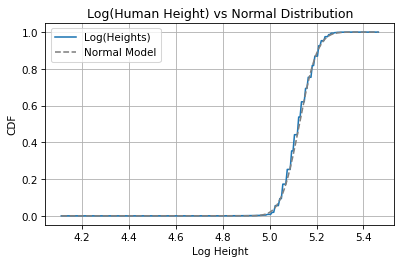

In [89]:
cdf_log_heights.plot(label="Log(Heights)")
cdf_log_normal.plot(label="Normal Model", ls="--", color="gray")
plt.title("Log(Human Height) vs Normal Distribution")
plt.xlabel("Log Height")
plt.ylabel("CDF")
plt.legend()
plt.grid(True)
plt.show()